# Semantic Similarity Analysis - Zoe (InferSent)

## Import libraries

In [37]:
import numpy as np
import pandas as pd
import csv
from random import randint

from scipy.spatial import distance

## Download InferSent2 model and fastText embeddings

In [18]:
! mkdir encoder
! curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl
  
# ! mkdir GloVe
# ! curl -Lo GloVe/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip
# ! unzip GloVe/glove.840B.300d.zip -d GloVe/

! mkdir fastText
! curl -Lo fastText/crawl-300d-2M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
! unzip fastText/crawl-300d-2M.vec.zip -d fastText/

mkdir: cannot create directory ‘encoder’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  15.7M      0  0:00:09  0:00:09 --:--:-- 16.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1453M  100 1453M    0     0  23.2M      0  0:01:02  0:01:02 --:--:-- 23.3M
Archive:  fastText/crawl-300d-2M.vec.zip
  inflating: fastText/crawl-300d-2M.vec  


## Set up file paths

In [19]:
cur_dir = 'drive/My Drive/Colab Notebooks/2 Fall 2020/CMPE 255/Project/'
path_train = cur_dir + 'sts-train.csv'
path_test = cur_dir + 'sts-test.csv'

## Read the training data

In [28]:
train_df = pd.read_table(
    path_train,
    error_bad_lines=False,
    skip_blank_lines=True,
    quoting=csv.QUOTE_NONE,
    usecols=[4, 5, 6],
    names=["similarity", "s1", "s2"])

train_df

,similarity,s1,s2
0,5.00,A plane is taking off.,An air plane is taking off.
1,3.80,A man is playing a large flute.,A man is playing a flute.
2,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,2.60,Three men are playing chess.,Two men are playing chess.
4,4.25,A man is playing the cello.,A man seated is playing the cello.
...,...,...,...
5744,0.00,Severe Gales As Storm Clodagh Hits Britain,Merkel pledges NATO solidarity with Latvia
5745,0.00,Dozens of Egyptians hostages taken by Libyan t...,Egyptian boat crash death toll rises as more b...
5746,0.00,President heading to Bahrain,President Xi: China to continue help to fight ...
5747,0.00,"China, India vow to further bilateral ties",China Scrambles to Reassure Jittery Stock Traders


## Load InferSent model and word embeddings

Import extra libraries and NLTK tokenizer

In [21]:
from models import InferSent
import torch

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Load model and embeddings

In [23]:
V = 2
model_path = 'encoder/infersent%s.pkl' % V
model_params = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
model = InferSent(model_params)
model.load_state_dict(torch.load(model_path))

# w2v_path = '/content/GloVe/glove.840B.300d.txt'
# model.set_w2v_path(w2v_path)

w2v_path = 'fastText/crawl-300d-2M.vec'
model.set_w2v_path(w2v_path)

## Create sentences list from the dataset for vocab

In [29]:
sentences = []
for row in train_df.iterrows():
    sentences.append(row[1][1])
    sentences.append(row[1][2])

print(len(sentences))
print(sentences[0])

11498
A plane is taking off.


## Build vocab for InferSent model from sentences list

In [30]:
model.build_vocab(sentences, tokenize=True)

Found 13746(/14417) words with w2v vectors
Vocab size : 13746


## Encode sentences

In [35]:
embeddings = model.encode(sentences, bsize=128, tokenize=False, verbose=True)
print('nb sentences encoded : {0}'.format(len(embeddings)))

Nb words kept : 123749/137342 (90.1%)
Speed : 64.4 sentences/s (cpu mode, bsize=128)
nb sentences encoded : 11498


## Visualizations

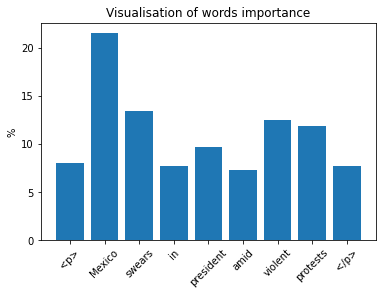

In [38]:
idx = randint(0, len(sentences))
_, _ = model.visualize(sentences[idx])

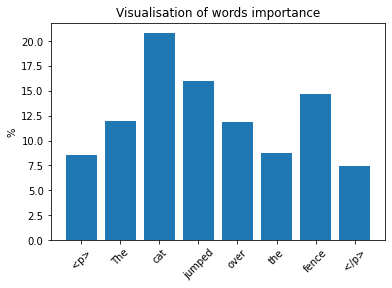

In [41]:
sample_sentence = 'The cat jumped over the fence'
_, _ = model.visualize(sample_sentence)

## Compare score from Infersent model vs. score from the dataset

In [42]:
index = 0
s1 = train_df.loc[index][1]
s2 = train_df.loc[index][2]
e1 = model.encode([s1])[0]
e2 = model.encode([s2])[0]
print('1:', s1)
print('2:', s2)
print()

print('cosine similarity for embeddings', round(distance.cosine(e1, e2), 6))
print('similarity score from dataset', train_df.loc[index][0])
print('similarity score from Infersent model', round((1 - distance.cosine(e1,e2))*5, 2))

1: A plane is taking off.
2: An air plane is taking off.

cosine similarity for embeddings 0.126774
similarity score from dataset 5.0
similarity score from Infersent model 4.37


## Store scores from the dataset

In [43]:
actual_scores = [s for s in train_df['similarity'].tolist()]
print(len(actual_scores))
print(actual_scores[1])

5749
3.8


## Calculate and store scores from InferSent model

In [44]:
infersent_scores = []
for row in train_df.iterrows():
    s1 = row[1][1]
    s2 = row[1][2]
    e1 = model.encode([s1])[0]
    e2 = model.encode([s2])[0]
    score = round((1 - distance.cosine(e1,e2))*5, 2)
    infersent_scores.append(score)
    if len(infersent_scores) % 100 == 0:
        print(len(infersent_scores))

print(len(infersent_scores))
print(infersent_scores[1])

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5749
4.53


## Analysis
Use Pearson correlation to compare actual and calculated scores

(Using GloVe embeddings, Pearson correlation was 52.93)

In [46]:
c = pd.Series(actual_scores).corr(pd.Series(infersent_scores))
print('Pearson correlation: %.2f' % (c*100))

Pearson correlation: 72.37


## Try using InferSent with different vocab words

### Load InferSent model and word embeddings

In [48]:
V = 2
model_path = 'encoder/infersent%s.pkl' % V
model_params = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
model2 = InferSent(model_params)
model2.load_state_dict(torch.load(model_path))

# w2v_path = '/content/GloVe/glove.840B.300d.txt'
# model2.set_w2v_path(w2v_path)

w2v_path = 'fastText/crawl-300d-2M.vec'
model2.set_w2v_path(w2v_path)

### Build vocab for InferSent model

Use K most common English words

In [52]:
model2.build_vocab_k_words(K=1000000)

Vocab size : 1000000


Update vocab with sentences list

In [53]:
model2.update_vocab(sentences)

Found 158(/829) words with w2v vectors
New vocab size : 1000159 (added 158 words)


### Encode sentences

In [54]:
embeddings = model2.encode(sentences, bsize=128, tokenize=False, verbose=True)
print('nb sentences encoded : {0}'.format(len(embeddings)))

Nb words kept : 130070/137342 (94.7%)
Speed : 64.9 sentences/s (cpu mode, bsize=128)
nb sentences encoded : 11498


### Visualizations

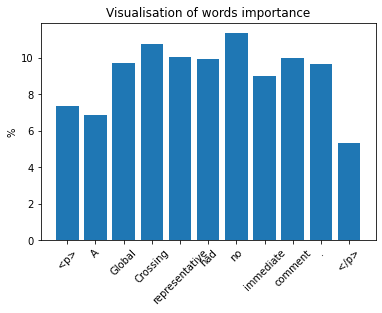

In [61]:
idx = randint(0, len(sentences))
_, _ = model2.visualize(sentences[idx])

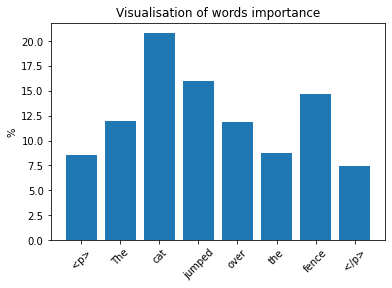

In [62]:
sample_sentence = 'The cat jumped over the fence'
_, _ = model2.visualize(sample_sentence)

### Compare score from Infersent model vs. score from the dataset

In [57]:
index = 0
s1 = train_df.loc[index][1]
s2 = train_df.loc[index][2]
e1 = model2.encode([s1])[0]
e2 = model2.encode([s2])[0]
print('1:', s1)
print('2:', s2)
print()

print('cosine similarity for embeddings', round(distance.cosine(e1, e2), 6))
print('similarity score from dataset', train_df.loc[index][0])
print('similarity score from Infersent model', round((1 - distance.cosine(e1,e2))*5, 2))

1: A plane is taking off.
2: An air plane is taking off.

cosine similarity for embeddings 0.126774
similarity score from dataset 5.0
similarity score from Infersent model 4.37


### Store scores from the dataset

In [58]:
actual_scores = [s for s in train_df['similarity'].tolist()]
print(len(actual_scores))
print(actual_scores[1])

5749
3.8


### Calculate and store scores from InferSent model

In [59]:
infersent_scores2 = []
for row in train_df.iterrows():
    s1 = row[1][1]
    s2 = row[1][2]
    e1 = model2.encode([s1])[0]
    e2 = model2.encode([s2])[0]
    score = round((1 - distance.cosine(e1,e2))*5, 2)
    infersent_scores2.append(score)
    if len(infersent_scores2) % 100 == 0:
        print(len(infersent_scores2))

print()
print(len(infersent_scores2))
print(infersent_scores2[1])

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700

5749
4.53


### Analysis
Use Pearson correlation to compare actual and calculated scores

(Using GloVe embeddings and vocab K=1000000, Pearson correlation was 52.96)

In [60]:
c = pd.Series(actual_scores).corr(pd.Series(infersent_scores2))
print('Pearson correlation: %.2f' % (c*100))

Pearson correlation: 72.37


## Compare scores for the test set

### Read the testing data

In [64]:
test_df = pd.read_table(
    path_test,
    error_bad_lines=False,
    skip_blank_lines=True,
    quoting=csv.QUOTE_NONE,
    usecols=[4, 5, 6],
    names=["similarity", "s1", "s2"])

test_df

,similarity,s1,s2
0,2.5,A girl is styling her hair.,A girl is brushing her hair.
1,3.6,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.
2,5.0,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.
3,4.2,A man is cutting up a cucumber.,A man is slicing a cucumber.
4,1.5,A man is playing a harp.,A man is playing a keyboard.
...,...,...,...
1374,0.0,"Philippines, Canada pledge to further boost re...",Philippines saves 100 after ferry sinks
1375,1.0,Israel bars Palestinians from Jerusalem's Old ...,"Two-state solution between Palestinians, Israe..."
1376,1.0,How much do you know about Secret Service?,Lawmakers from both sides express outrage at S...
1377,0.0,Obama Struggles to Soothe Saudi Fears As Iran ...,Myanmar Struggles to Finalize Voter Lists for ...


### Compare score from Infersent model vs. score from the dataset

In [66]:
index = 1
s1 = test_df.loc[index][1]
s2 = test_df.loc[index][2]
e1 = model.encode([s1])[0]
e2 = model.encode([s2])[0]
print('1:', s1)
print('2:', s2)
print()

print('cosine similarity for embeddings', round(distance.cosine(e1, e2), 6))
print('similarity score from dataset', test_df.loc[index][0])
print('similarity score from Infersent model', round((1 - distance.cosine(e1,e2))*5, 2))

1: A group of men play soccer on the beach.
2: A group of boys are playing soccer on the beach.

cosine similarity for embeddings 0.09056
similarity score from dataset 3.6
similarity score from Infersent model 4.55


### Store scores from the dataset

In [70]:
actual_test_scores = [s for s in test_df['similarity'].tolist()]
print(len(actual_test_scores))
print(actual_test_scores[1])

1379
3.6


### Calculate and store scores from InferSent model

In [71]:
infersent_test_scores = []
for row in test_df.iterrows():
    s1 = row[1][1]
    s2 = row[1][2]
    e1 = model.encode([s1])[0]
    e2 = model.encode([s2])[0]
    score = round((1 - distance.cosine(e1,e2))*5, 2)
    infersent_test_scores.append(score)
    if len(infersent_test_scores) % 100 == 0:
        print(len(infersent_test_scores))

# print()
print(len(infersent_test_scores))
print(infersent_test_scores[1])

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1379
4.55


### Analysis
Use Pearson correlation to compare actual and calculated scores

In [73]:
c = pd.Series(actual_test_scores).corr(pd.Series(infersent_test_scores))
print('Pearson correlation: %.2f' % (c*100))

Pearson correlation: 66.56
